In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

np.random.seed(42)

#   Multi-Dimensional Integration with MCMC

-----

By Megan Bedell (Flatiron Institute)

10 September 2019

### Problem 1: Fitting a Sinusoid to Data

In this example, we will download a time series of radial velocities for the star HD209458. This star hosts a Hot Jupiter exoplanet. In fact, [this planet](https://en.wikipedia.org/wiki/HD_209458_b) was the first to be seen in transit and was discovered 20 years ago yesterday!

Because the eccentricity is low for this planet, we can fit its orbit in the radial velocities with a relatively simple model: a sinusoid.

Below is a snippet of code that will download the time-series data from [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/):

In [0]:
datafile = 'https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0108/0108859/data/UID_0108859_RVC_001.tbl'
data = pd.read_fwf(datafile, header=0, names=['t', 'rv', 'rv_err'], skiprows=22)
data['t'] -= data['t'][0]

#### Problem 1a
Plot the data. Let's take a look at what we're working with!

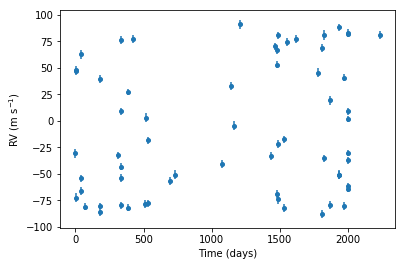

In [3]:
fig, ax = plt.subplots()
ax.errorbar(data['t'], data['rv'], data['rv_err'], fmt='o', ms=4)
ax.set_xlabel('Time (days)')
ax.set_ylabel(r'RV (m s$^{-1}$)');

#### Problem 1b

Write the sinusoid function that we want to fit.

In [0]:
def get_model_predictions(theta, t):
  '''
  Calculate RV predictions for parameters theta and timestamps t.
  '''
  period, amplitude, t0, rv0 = theta
  model_preds = amplitude * np.sin(2. * np.pi / period * (t - t0)) + rv0
  return model_preds

The following functions should be imported from the previous day's Metropolis-Hastings exercise:

In [0]:
def lnlikelihood(theta, y, x, y_unc):
    model_preds = get_model_predictions(theta, x)
    
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl
  
def nll(theta, y, x, y_unc):
    return -1. * lnlikelihood(theta, y, x, y_unc)
  
def lnprior(theta):
    period, amplitude, t0, rv0 = theta
    if 0 < period <= 1e4 and 0 <= amplitude <= 1e3:
        lnp = np.log(1e-4) + np.log(1e-3)
    else:
        return -np.inf
    
    return lnp
  

def lnposterior(theta, y, x, y_unc):
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc)
    lnpost = lnl + lnp
        
    return lnpost

def hastings_ratio(theta_1, theta_0, y, x, y_unc):
    lnpost1 = lnposterior(theta_1, y, x, y_unc)
    lnpost0 = lnposterior(theta_0, y, x, y_unc)
    
    h_ratio = np.exp(lnpost1)/np.exp(lnpost0)
    
    return h_ratio
  

def propose_jump(theta, cov):
    if np.shape(theta) == np.shape(cov):
        cov = np.diag(np.array(cov)**2)
    
    proposed_position = np.random.multivariate_normal(theta, cov)
    
    return proposed_position
  
def mh_mcmc(theta_0, cov, nsteps, y, x, y_unc):
    
    positions = np.zeros((nsteps+1, len(theta_0)))
    lnpost_at_pos = -np.inf*np.ones(nsteps+1)
    acceptance_ratio = np.zeros_like(lnpost_at_pos)
    accepted = 0
    
    positions[0] = theta_0
    lnpost_at_pos[0] = lnposterior(theta_0, y, x, y_unc)
    
    for step_num in np.arange(1, nsteps+1):
        proposal = propose_jump(positions[step_num-1], cov)
        H = hastings_ratio(proposal, positions[step_num-1], y, x, y_unc)
        R = np.random.uniform()
        
        if H > R:
            accepted += 1
            positions[step_num] = proposal
            lnpost_at_pos[step_num] = lnposterior(proposal, y, x, y_unc)
            acceptance_ratio[step_num] = float(accepted)/step_num
        else:
            positions[step_num] = positions[step_num-1]
            lnpost_at_pos[step_num] = lnpost_at_pos[step_num-1]
            acceptance_ratio[step_num] = float(accepted)/step_num
    
    return (positions, lnpost_at_pos, acceptance_ratio)
 

#### Problem 1c

Find a good set of initialization values by optimizing.

To save some time, I will assert that if we made a Lomb-Scargle periodogram of the RVs, there would be a peak around period = 3.52-3.53 days, so start with that guess and let's figure out what the best values might be for the other parameters.

(If you finish early and are up for a bonus problem, you can double-check my assertion using [astropy timeseries](https://docs.astropy.org/en/stable/timeseries/lombscargle.html)!)

In [0]:
theta_0 = [3.53, 100, 0, 0] # [period, amplitude, t0] starting guesses

In [7]:
from scipy.optimize import minimize
res = minimize(nll, theta_0, 
               args=(data['rv'], data['t'], data['rv_err']),
              method='Nelder-Mead')
print('Optimizer finished with message "{0}" and \n\
      best-fit parameters {1}'.format(res['message'], res['x']))

Optimizer finished with message "Optimization terminated successfully." and 
      best-fit parameters [ 3.52472578 84.2442877   0.21263976 -0.18676049]


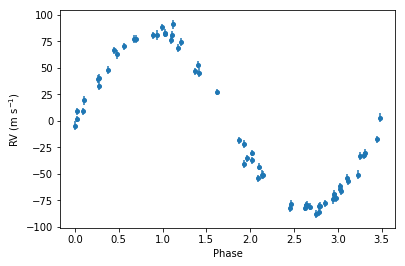

In [8]:
fig, ax = plt.subplots()
ax.errorbar((data['t'] - res['x'][2]) % res['x'][0], data['rv'], data['rv_err'],
            fmt='o', ms=4)
ax.set_xlabel('Phase')
ax.set_ylabel(r'RV (m s$^{-1}$)');

#### Problem 1d

Run the MCMC!

In [0]:
theta_0 = res['x']
cov = [0.001, 0.1, 0.01, 0.1]
pos, lnpost, acc = mh_mcmc(theta_0, cov, 5000, data['rv'], data['t'], data['rv_err'])

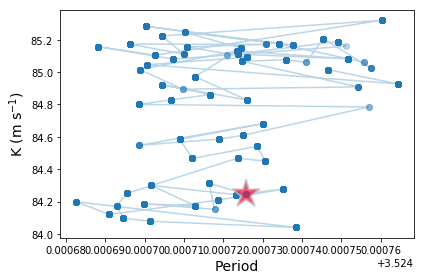

In [14]:
fig, ax = plt.subplots()
ax.plot(pos[:,0], pos[:,1], 'o-', alpha=0.3)
ax.plot(theta_0[0], theta_0[1], '*', ms=30, 
        mfc='Crimson', mec='0.8', mew=2, 
        alpha=0.7)
ax.set_xlabel('Period', fontsize=14)
ax.set_ylabel(r'K (m s$^{-1}$)', fontsize=14)
fig.tight_layout()

#### Problem 1e

Calculate the auto-correlation length of your chain.

First, let's just plot the sequence of orbital period values in the chain. From eyeballing this sequence, how many steps do you think are needed to reach a sample that is independent from the previous one(s)?

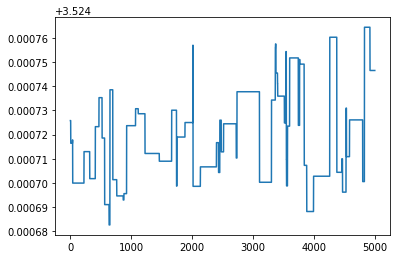

In [13]:
plt.plot(pos[:,0]);

#### Problem 1f

Change the step size of the MCMC. What does this do to the auto-correlation length? Does this seem better or worse, and why?

In [0]:
cov = [0.0001, 0.1, 0.01, 0.1]
pos, lnpost, acc = mh_mcmc(theta_0, cov, 5000, data['rv'], data['t'], data['rv_err'])

#### Problem 1g

Start the MCMC in a different region of parameter space. What happens to the resulting chain?

#### Problem 1h

Using the step sizes and starting conditions that you deem best, run your MCMC for *at least* 1000x the auto-correlation length to get a large number of independent samples. Plot the posterior distribution of radial velocity semi-amplitude K. This parameter is arguably the most important output of an RV fit, because it is a measurement of the mass of the planet. 

From these results, what can we say about the true value of K? What is the probability that K > 84 m/s? 85 m/s? 90 m/s?

### Problem 2: Fitting a Keplerian to Data

In the previous example, the orbit we were fitting had negligible eccentricity, so we were able to fit it with a sinusoid. In this example, we'll look at the high-eccentricity planet HD 80606b and fit a full Keplerian model to its RV data. This requires introducing some new free parameters to the model, which as we will see are not always straightforward to sample!

In [0]:
datafile = 'https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0045/0045982/data/UID_0045982_RVC_006.tbl'
data = pd.read_fwf(datafile, header=0, names=['t', 'rv', 'rv_err'], skiprows=21)
data['t'] -= data['t'][0]